In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',100000000)

### Data Dictionary (Will edit later)


raw/metadata.json
--------
The file contains information about movies from MovieLens - 84,661 lines of json objects that have the following fields:

title – movie title (84,484 unique titles)

directedBy – directors separated by comma (‘,’)

starring – actors separated by comma (‘,’)

dateAdded – date, when the movie was added to MovieLens

avgRating – average rating of a movie, scale of 0.5 to 5

imdbId – movie id on the IMDB website (84,661 unique ids)

item_id – movie id, which is consistent across files (84,661 unique ids)

Example line:
{"title": "Toy Story (1995)", "directedBy": "John Lasseter", "starring": "Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts", "dateAdded": null, "avgRating": 3.89146, "imdbId": "0114709", "item_id": 1}


raw/reviews.json
--------
The file contains 2,624,608 lines of movie reviews collected from the IMDB website. The json objects have the following fields:

item_id – movie id (52,081 unique ids)

txt – review text

Example line:
{"item_id": 172063, "txt": "one-shot record of a belly dancer; \"Carmencita Dancing,\" one of a series of Edison short films featuring \r circus and vaudeville acts, displayed the... um... \"talents\" of a zaftig belly-dancer who agreed to undulate before the camera of the famous \"Black \r Maria\" studio. \r \r The dance was originally intended to be played in a Kinetoscope, a single -person arcade viewer connected to Edison's more famous invention, the phonograph. Through a pair of crude headphones, the latter device supplied an asynchronous soundtrack of \"hootchie-cootchie\" music. \r \r The Kinetograph camera here employed is so new -- even to its inventors \r -- that director Dickson has drastically \"overcranked\" the film, unintentionally producing one of the first examples of slow-motion.\r \r Carmencita's titillating movements were considered by many to be \r scandalous. Thus, the film prompted some of the earliest discussions of film censorship."}

### Movies

In [4]:
metadata_raw = pd.read_json(r"C:\Users\micha\OneDrive\Desktop\Capstone\movie_dataset_public_final\raw\metadata.json", lines=True)

In [5]:
metadata_raw.head()

,title,directedBy,starring,dateAdded,avgRating,imdbId,item_id
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",None,3.89146,114709,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",None,3.26605,113497,2
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",None,3.17146,113228,3
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",None,2.86824,114885,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",None,3.07620,113041,5


In [6]:
metadata_raw.shape

(84661, 7)

In [7]:
metadata_raw = metadata_raw.replace(r'^\s*$', pd.np.nan, regex=True)



In [8]:
# only missing info from dateAdded
metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       84661 non-null  object 
 1   directedBy  81511 non-null  object 
 2   starring    77778 non-null  object 
 3   dateAdded   78143 non-null  object 
 4   avgRating   84661 non-null  float64
 5   imdbId      84661 non-null  int64  
 6   item_id     84661 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 4.5+ MB


In [9]:
# Date added is not the same as year release date, imdbID is not used to join any columns, can drop
metadata_raw.drop(columns=['dateAdded', 'imdbId'], inplace=True)  

In [10]:
# Drop all rows that contain NaN values
metadata_raw = metadata_raw.dropna()


In [11]:
# roughly 15% of data is not clean
# Date added is not release date, can drop
metadata_raw.isna().sum(axis=0) / metadata_raw.shape[0]*100

title         0.0
directedBy    0.0
starring      0.0
avgRating     0.0
item_id       0.0
dtype: float64

In [12]:
## No duplicate entries, good 
metadata_raw.duplicated().sum()

0

In [13]:
metadata_raw['Year'] = metadata_raw['title'].str.extract(r'\((\d{4})\)$')

In [14]:
metadata_raw.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",3.89146,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",3.26605,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",3.17146,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",2.86824,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",3.07620,5,1995


In [15]:
# Year gets dropped down to 1 Percent missing
metadata_raw.isna().sum(axis=0) / metadata_raw.shape[0]*100

title         0.00000
directedBy    0.00000
starring      0.00000
avgRating     0.00000
item_id       0.00000
Year          0.53443
dtype: float64

In [16]:
# Change Data type so it's numerical
metadata_raw['Year'] = metadata_raw['Year'].astype('Int64')

In [17]:
metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76343 entries, 0 to 84659
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       76343 non-null  object 
 1   directedBy  76343 non-null  object 
 2   starring    76343 non-null  object 
 3   avgRating   76343 non-null  float64
 4   item_id     76343 non-null  int64  
 5   Year        75935 non-null  Int64  
dtypes: Int64(1), float64(1), int64(1), object(3)
memory usage: 4.1+ MB


In [18]:
metadata_raw.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",3.89146,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",3.26605,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",3.17146,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",2.86824,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",3.07620,5,1995


In [19]:
# roughly 15% of data is not clean
# Date added is not release date, can drop
metadata_raw.isna().sum(axis=0) / metadata_raw.shape[0]*100

title         0.00000
directedBy    0.00000
starring      0.00000
avgRating     0.00000
item_id       0.00000
Year          0.53443
dtype: float64

In [20]:
# We can tell that they are all individual movies, ... going to have to remove all of them with the na values
metadata_raw[metadata_raw['Year'].isna()]

,title,directedBy,starring,avgRating,item_id,Year
8496,"Babe Ruth Story, The (1948)",Roy Del Ruth,"William Bendix, Claire Trevor, Charles Bickford",2.50000,25936,<NA>
8636,"Heroes of Telemark, The (1965)",Anthony Mann,"Kirk Douglas, Richard Harris, Ulla Jacobsson,Michael Redgrave",2.85714,26137,<NA>
8964,Jack's Back (1988),Rowdy Herrington,"James Spader, Cynthia Gibb, Jim Haynie",3.06522,26628,<NA>
9174,From Dusk Till Dawn 2: Texas Blood Money (1999),Scott Spiegel,"Bruce Campbell, Danny Trejo, Robert Patrick, Muse Watson, Brett Harrelson, Bo Hopkins, Raymond Cruz, Duane Whitaker",2.12222,27008,<NA>
9237,After the Rain (Ame agaru) (1999),Takashi Koizumi,"Akira Terao, Yoshiko Miyazaki, Shirô Mifune",3.75926,27189,<NA>
...,...,...,...,...,...,...
81979,The Woman in the Window,Joe Wright,"Amy Adams,Gary Oldman,Jennifer Jason Leigh,Julianne Moore,Wyatt Russell",0.00000,233953,<NA>
82792,Obsessed With the Babysitter,Brian Skiba,"Hannah Aniela,Lyla Emerson Booker,Jayd'n Harris,Simon Haycock,Dom Huynh",1.00000,235579,<NA>
84225,Grass Roots,Jerry London,"Corbin Bernsen,Claude Akins,Donzaleigh Abernathy,Karen Beyer",0.00000,238444,<NA>
84278,The Craven Cove Murders,Ron Ford,"Randal Malone,Trish Haight,Ted Newsom",0.00000,238550,<NA>


In [21]:
metadata_raw = metadata_raw[pd.notnull(metadata_raw['Year'])]

In [22]:
# Kept All columns without null values
metadata_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75935 entries, 0 to 84659
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       75935 non-null  object 
 1   directedBy  75935 non-null  object 
 2   starring    75935 non-null  object 
 3   avgRating   75935 non-null  float64
 4   item_id     75935 non-null  int64  
 5   Year        75935 non-null  Int64  
dtypes: Int64(1), float64(1), int64(1), object(3)
memory usage: 4.1+ MB


In [23]:
# Checking if the lowest year is reasonable (not like 1200 or something)
metadata_raw['Year'].describe()

count    75935.000000
mean      1993.618108
std         24.946430
min       1880.000000
25%       1978.000000
50%       2003.000000
75%       2013.000000
max       2021.000000
Name: Year, dtype: float64

(array([2.5000e+01, 1.0300e+02, 4.3700e+02, 2.0240e+03, 3.7760e+03,
        5.0980e+03, 7.6550e+03, 8.7620e+03, 1.5003e+04, 3.3052e+04]),
 array([1880.0, 1894.1, 1908.2, 1922.3, 1936.4, 1950.5, 1964.6, 1978.7,
        1992.8, 2006.9, 2021.0], dtype=object),
 <BarContainer object of 10 artists>)

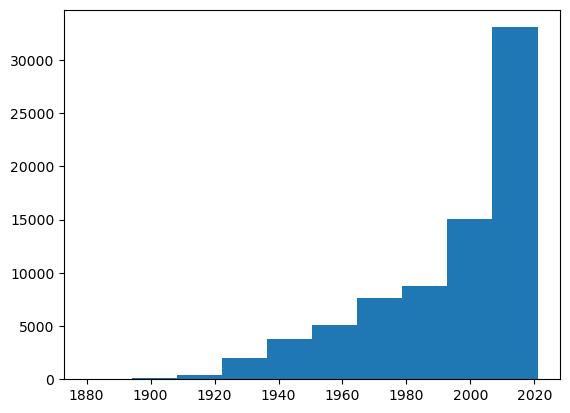

In [24]:
# Looks good, no awkward years atm 
plt.hist(metadata_raw['Year'].values)

In [25]:
# Want to add a multiplier to bring the values of movie reviews from a range of 0.5-5 to 1-10

metadata_raw['avgRating'] = metadata_raw['avgRating'].multiply(2)

In [26]:
metadata_raw.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78292,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53210,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34292,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.73648,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15240,5,1995


In [27]:
# rounding all avgrating to 2 decimal place.

metadata_raw['avgRating'] = metadata_raw['avgRating'].round(2)


In [28]:
# Checking the rating, we see the ratings have a minimum of 0
# previously we checked for null values and there are none fortunately
# remove the movies that have less than a rating of 1
metadata_raw['avgRating'].describe()

count    75935.000000
mean         5.093611
std          2.600895
min          0.000000
25%          4.200000
50%          6.000000
75%          6.930000
max         10.000000
Name: avgRating, dtype: float64

In [29]:
# Should be last thing that is from the original dataset that needs to be addressed, joining columns afterwards
cleaner_df = metadata_raw[(metadata_raw['avgRating']>=1)]

In [30]:
# Still a big enough dataset, 70k entries
cleaner_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63769 entries, 0 to 84561
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       63769 non-null  object 
 1   directedBy  63769 non-null  object 
 2   starring    63769 non-null  object 
 3   avgRating   63769 non-null  float64
 4   item_id     63769 non-null  int64  
 5   Year        63769 non-null  Int64  
dtypes: Int64(1), float64(1), int64(1), object(3)
memory usage: 3.5+ MB


In [31]:
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995


In [32]:
# cool, minimum value of avg rating is now 1
cleaner_df['avgRating'].describe()

count    63769.000000
mean         6.065382
std          1.470032
min          1.000000
25%          5.290000
50%          6.210000
75%          7.000000
max         10.000000
Name: avgRating, dtype: float64

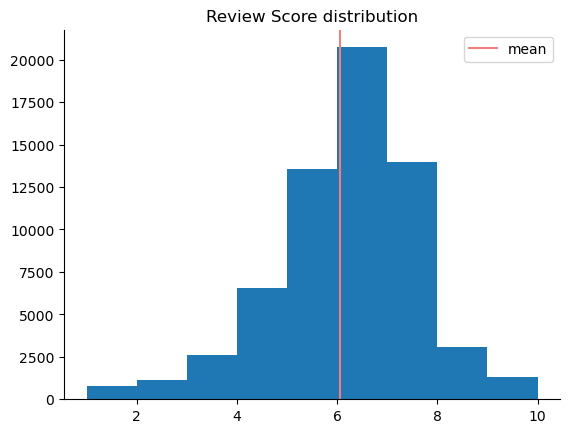

In [33]:
# Basic histogram plot, 
plt.hist(cleaner_df['avgRating'], bins=9)

# Plots mean 
plt.axvline(cleaner_df['avgRating'].mean(), 0, 1000, label="mean", color="lightcoral")

plt.title("Review Score distribution")
sns.despine()
plt.legend()
plt.show()

In [34]:
# Create a sentiment column if rating is 7.0 or above, 1

cleaner_df['Sentiment'] = np.where(cleaner_df['avgRating'] >= 7, 1, 0)
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0


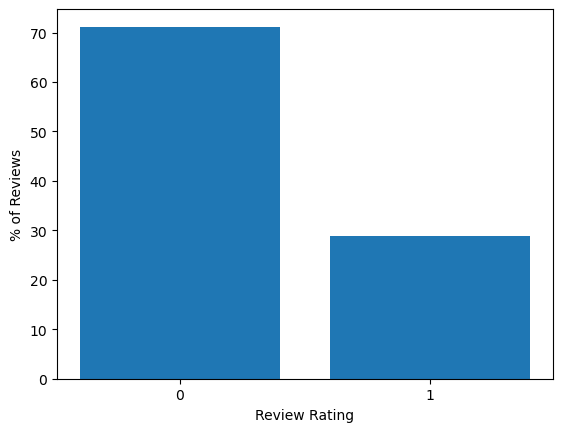

Class imbalance: [0.71 0.29]


In [35]:
values, counts = np.unique(cleaner_df['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Rating')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

In [36]:
# we can assume that theres only one director per movie, but maybe there's an additional credit, lets count the number of words in each directedBy entry

cleaner_df['director_count'] = cleaner_df['directedBy'].str.split(",").apply(len)

In [37]:
cleaner_df.head(20)

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,director_count
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,1
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,1
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,1
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,1
5,Heat (1995),Michael Mann,"Robert De Niro, Al Pacino, Val Kilmer, Jon Voight, Tom Sizemore, Ashley Judd, Diane Venora, Natalie Portman",7.71,6,1995,1,1
6,Sabrina (1995),Sydney Pollack,"Harrison Ford, Greg Kinnear, Nancy Marchand, Julia Ormond",6.74,7,1995,0,1
7,Tom and Huck (1995),Peter Hewitt,"Jonathan Taylor Thomas, Brad Renfro, Eric Schweig, Charles Rocket, Amy Wright, Michael McShane, Marian Seldes, Rachael Leigh Cook, Peter Mackenzie, Andy Stahl, Adrian Roberts, David Cowgill, Ike Eisenmann, Tamara Mello, Courtney Peldon",6.23,8,1995,0,1
8,Sudden Death (1995),Peter Hyams,"Raymond J. Barry, Powers Boothe, Jean-Claude Van Damme, Whittni Wright",6.00,9,1995,0,1
9,GoldenEye (1995),Martin Campbell,"Pierce Brosnan, Sean Bean, Famke Janssen, Izabella Scorupco, Joe Don Baker, Judi Dench, Robbie Coltrane, Alan Cumming, Tchéky Karyo, Desmond Llewelyn, Samantha Bond",6.87,10,1995,0,1


In [38]:
cleaner_df['director_count'].value_counts()

1     62035
2      1473
3       144
4        38
5        22
7        16
6        15
8         7
11        4
9         3
13        2
10        2
26        2
36        1
25        1
15        1
12        1
27        1
30        1
Name: director_count, dtype: int64

In [39]:
# Large number of them seem to be single director or 2 or 3, lets investigate the percent of them
# 97% of a large database like this might be more reasonable to drop them?

cleaner_df['director_count'].value_counts(normalize = True)

1     0.972808
2     0.023099
3     0.002258
4     0.000596
5     0.000345
7     0.000251
6     0.000235
8     0.000110
11    0.000063
9     0.000047
13    0.000031
10    0.000031
26    0.000031
36    0.000016
25    0.000016
15    0.000016
12    0.000016
27    0.000016
30    0.000016
Name: director_count, dtype: float64

In [40]:
cleaner_df.drop(columns=['director_count'], inplace=True)

In [41]:
# x amount of movies director made

cleaner_df['directedBy'] = cleaner_df['directedBy'].str.split(',').str[0]

In [42]:
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0


In [43]:
cleaner_df['#Movies_directed'] = cleaner_df.groupby('directedBy')['directedBy'].transform('count')

In [44]:
cleaner_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,#Movies_directed
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,6
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,9
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,11
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,7


In [45]:
cleaner_df['#Movies_directed'].value_counts()

1     16078
2      8080
3      5679
4      4300
5      3240
6      2760
7      2436
8      1936
9      1719
10     1470
11     1342
13     1196
12     1092
15     1020
16      992
14      924
18      702
19      665
22      616
17      578
23      552
21      546
20      480
24      456
25      450
26      364
33      363
30      360
32      320
27      270
29      261
34      238
39      234
28      168
42      168
36      144
44      132
38      114
37      111
49       98
31       93
46       92
45       90
43       86
41       82
40       80
77       77
35       70
69       69
68       68
55       55
53       53
52       52
51       51
50       50
47       47
Name: #Movies_directed, dtype: int64

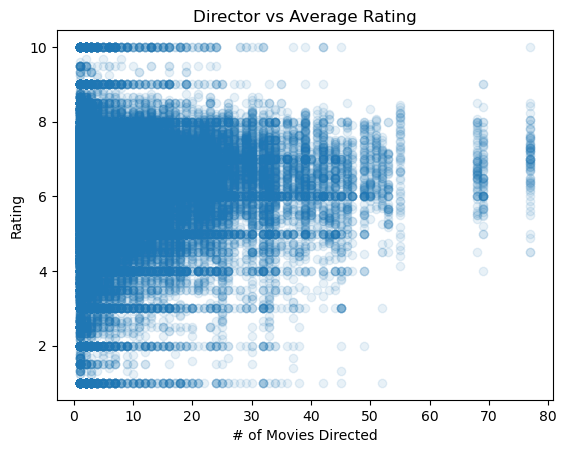

In [46]:
plt.figure()

plt.scatter(cleaner_df['#Movies_directed'], cleaner_df['avgRating'], alpha=0.1) # change the transparency with the alpha param, between 0 and 1

plt.xlabel('# of Movies Directed')
plt.ylabel('Rating')
plt.title('Director vs Average Rating')

plt.show()

In [47]:
# Gets a column counting by actors, we see it's seperated by commas
cleaner_df['actor_count'] = cleaner_df["starring"].str.count(",") + 1

In [48]:
# 5 actors is the starring list's most common

cleaner_df['actor_count'].value_counts(normalize = True)

5     0.518104
4     0.173878
3     0.100488
1     0.044771
2     0.043908
6     0.034280
7     0.020214
8     0.014239
9     0.010068
10    0.007731
11    0.006414
12    0.005206
13    0.003999
15    0.003324
14    0.003152
16    0.001678
17    0.001600
18    0.001443
20    0.000862
19    0.000831
21    0.000800
22    0.000455
24    0.000376
23    0.000282
29    0.000251
25    0.000235
28    0.000220
26    0.000220
27    0.000188
30    0.000157
31    0.000110
32    0.000094
35    0.000063
41    0.000047
36    0.000047
33    0.000031
34    0.000031
37    0.000031
40    0.000031
57    0.000031
70    0.000016
38    0.000016
45    0.000016
52    0.000016
51    0.000016
65    0.000016
42    0.000016
Name: actor_count, dtype: float64

In [49]:
# 5 actors also makes up almost 90% of the dataset.
# limit it to top 5 actors.

cleaner_df['actor_count'].value_counts(normalize=True).sort_index().cumsum()

1     0.044771
2     0.088679
3     0.189167
4     0.363045
5     0.881149
6     0.915429
7     0.935643
8     0.949882
9     0.959949
10    0.967680
11    0.974094
12    0.979300
13    0.983299
14    0.986451
15    0.989776
16    0.991454
17    0.993053
18    0.994496
19    0.995327
20    0.996189
21    0.996989
22    0.997444
23    0.997726
24    0.998103
25    0.998338
26    0.998557
27    0.998745
28    0.998965
29    0.999216
30    0.999373
31    0.999483
32    0.999577
33    0.999608
34    0.999639
35    0.999702
36    0.999749
37    0.999780
38    0.999796
40    0.999828
41    0.999875
42    0.999890
45    0.999906
51    0.999922
52    0.999937
57    0.999969
65    0.999984
70    1.000000
Name: actor_count, dtype: float64

In [50]:
cleaner_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63769 entries, 0 to 84561
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             63769 non-null  object 
 1   directedBy        63769 non-null  object 
 2   starring          63769 non-null  object 
 3   avgRating         63769 non-null  float64
 4   item_id           63769 non-null  int64  
 5   Year              63769 non-null  Int64  
 6   Sentiment         63769 non-null  int32  
 7   #Movies_directed  63769 non-null  int64  
 8   actor_count       63769 non-null  int64  
dtypes: Int64(1), float64(1), int32(1), int64(3), object(3)
memory usage: 4.7+ MB


In [51]:
# map anyhting over 5 to 5
cleaner_df['actor_count'] = np.where(cleaner_df['actor_count'] >= 5, 5, cleaner_df['actor_count'])

In [52]:
cleaner_df['actor_count'].value_counts(normalize = True)

5    0.636955
4    0.173878
3    0.100488
1    0.044771
2    0.043908
Name: actor_count, dtype: float64

In [53]:

actors_list = []

for index, row in cleaner_df.iterrows():
    # Split the "starring" column by commas to get a list of actors
    cols = row['starring'].split(",")
    if len(cols) < 5:
        cols += [0] * (5 - len(cols))
    else:
        cols = cols[:5]
    
    # Add the list of actors to the list of actor lists
    actors_list.append(cols)

# make it a dataframe
actors_df = pd.DataFrame(actors_list, columns=['Actor 1', 'Actor 2', 'Actor 3', 'Actor 4', 'Actor 5'])

# Look at new table
actors_df.head()

,Actor 1,Actor 2,Actor 3,Actor 4,Actor 5
0,Tim Allen,Tom Hanks,Don Rickles,Jim Varney,John Ratzenberger
1,Jonathan Hyde,Bradley Pierce,Robin Williams,Kirsten Dunst,0
2,Jack Lemmon,Walter Matthau,Ann-Margret,Sophia Loren,0
3,Angela Bassett,Loretta Devine,Whitney Houston,Lela Rochon,0
4,Steve Martin,Martin Short,Diane Keaton,Kimberly Williams,George Newbern


In [54]:
print(actors_df.shape)

(63769, 5)


In [55]:
#exclude 0s
# Flatten the dataframe and count the appearances of each actor
actor_counts = actors_df.stack().value_counts()

# Create a new dataframe with total appearances for each row
total_appearances_df = pd.DataFrame()
for index, row in actors_df.iterrows():
    actors = [actor for actor in row.values if actor != 0]
    total_appearances = actor_counts.loc[actors].sum()
    total_appearances_df = total_appearances_df.append(pd.DataFrame({'total_appearances': [total_appearances]}), ignore_index=True)


In [56]:

# Display the new dataframe
total_appearances_df.head()

,total_appearances
0,66
1,52
2,80
3,33
4,75


In [57]:
# combine the appearance number with the actors dataframe
actors_appearances_df = pd.concat([actors_df.reset_index(drop=True), total_appearances_df.reset_index(drop=True)], axis = 1)

In [58]:
# append the actors dataframe to the original dataset
# Reset index to avoid adding new rows
movies_df = pd.concat([cleaner_df.reset_index(drop=True), actors_appearances_df.reset_index(drop=True)], axis = 1)

In [59]:
movies_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,#Movies_directed,actor_count,Actor 1,Actor 2,Actor 3,Actor 4,Actor 5,total_appearances
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,6,5,Tim Allen,Tom Hanks,Don Rickles,Jim Varney,John Ratzenberger,66
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,9,4,Jonathan Hyde,Bradley Pierce,Robin Williams,Kirsten Dunst,0,52
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,11,4,Jack Lemmon,Walter Matthau,Ann-Margret,Sophia Loren,0,80
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,4,4,Angela Bassett,Loretta Devine,Whitney Houston,Lela Rochon,0,33
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,7,5,Steve Martin,Martin Short,Diane Keaton,Kimberly Williams,George Newbern,75


In [60]:
movies_df['Celeb_score'] = movies_df['total_appearances'] / movies_df['actor_count']



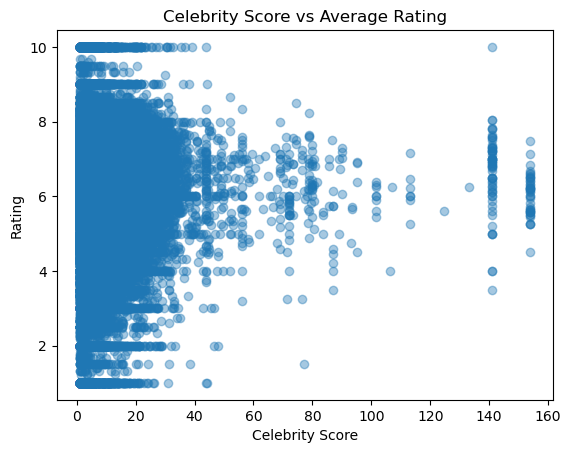

In [61]:
plt.figure()

plt.scatter(movies_df['Celeb_score'], movies_df['avgRating'], alpha=0.4) # change the transparency with the alpha param, between 0 and 1

plt.xlabel('Celebrity Score')
plt.ylabel('Rating')
plt.title('Celebrity Score vs Average Rating')

plt.show()

In [62]:
movies_df.drop(columns=['total_appearances'], inplace=True)

In [63]:
movies_df.head()

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,#Movies_directed,actor_count,Actor 1,Actor 2,Actor 3,Actor 4,Actor 5,Celeb_score
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,6,5,Tim Allen,Tom Hanks,Don Rickles,Jim Varney,John Ratzenberger,13.20
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,9,4,Jonathan Hyde,Bradley Pierce,Robin Williams,Kirsten Dunst,0,13.00
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,11,4,Jack Lemmon,Walter Matthau,Ann-Margret,Sophia Loren,0,20.00
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,4,4,Angela Bassett,Loretta Devine,Whitney Houston,Lela Rochon,0,8.25
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,7,5,Steve Martin,Martin Short,Diane Keaton,Kimberly Williams,George Newbern,15.00


In [64]:
# no nulls and everything seems so have the right data type
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63769 entries, 0 to 63768
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             63769 non-null  object 
 1   directedBy        63769 non-null  object 
 2   starring          63769 non-null  object 
 3   avgRating         63769 non-null  float64
 4   item_id           63769 non-null  int64  
 5   Year              63769 non-null  Int64  
 6   Sentiment         63769 non-null  int32  
 7   #Movies_directed  63769 non-null  int64  
 8   actor_count       63769 non-null  int64  
 9   Actor 1           63769 non-null  object 
 10  Actor 2           63769 non-null  object 
 11  Actor 3           63769 non-null  object 
 12  Actor 4           63769 non-null  object 
 13  Actor 5           63769 non-null  object 
 14  Celeb_score       63769 non-null  float64
dtypes: Int64(1), float64(2), int32(1), int64(3), object(8)
memory usage: 7.1+ MB


In [65]:
# Keep this section for lin reg model without word analysis
    
linreg_movies_df = movies_df.copy()



In [66]:
linreg_movies_df

,title,directedBy,starring,avgRating,item_id,Year,Sentiment,#Movies_directed,actor_count,Actor 1,Actor 2,Actor 3,Actor 4,Actor 5,Celeb_score
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney, John Ratzenberger, Wallace Shawn, Laurie Metcalf, John Morris, R. Lee Ermey, Annie Potts",7.78,1,1995,1,6,5,Tim Allen,Tom Hanks,Don Rickles,Jim Varney,John Ratzenberger,13.20
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams, Kirsten Dunst",6.53,2,1995,0,9,4,Jonathan Hyde,Bradley Pierce,Robin Williams,Kirsten Dunst,0,13.00
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sophia Loren",6.34,3,1995,0,11,4,Jack Lemmon,Walter Matthau,Ann-Margret,Sophia Loren,0,20.00
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Houston, Lela Rochon",5.74,4,1995,0,4,4,Angela Bassett,Loretta Devine,Whitney Houston,Lela Rochon,0,8.25
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimberly Williams, George Newbern, Kieran Culkin",6.15,5,1995,0,7,5,Steve Martin,Martin Short,Diane Keaton,Kimberly Williams,George Newbern,15.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63764,Stump the Guesser (2020),Guy Maddin,"Adam Brooks,Stephanie Berrington,Brent Neale,Werner Thaller,Alison Lord",8.00,239042,2020,1,15,5,Adam Brooks,Stephanie Berrington,Brent Neale,Werner Thaller,Alison Lord,1.80
63765,Swiss Family Robinson (1940),Edward Ludwig,"Thomas Mitchell,Edna Best,Freddie Bartholomew,Terry Kilburn,Tim Holt",3.00,239048,1940,0,8,5,Thomas Mitchell,Edna Best,Freddie Bartholomew,Terry Kilburn,Tim Holt,5.60
63766,It Happened One Valentine's (2017),Jake Helgren,"James Maslow,Haley Webb,Brittany Underwood,Lindsay Hartley,Courtney Gains",10.00,239062,2017,1,8,5,James Maslow,Haley Webb,Brittany Underwood,Lindsay Hartley,Courtney Gains,5.20
63767,Sweeney Todd: The Demon Barber of Fleet Street (2014),Lonny Price,"Emma Thompson,Bryn Terfel,Jeff Blumenkrantz,Christian Borle,Kyle Brenn",8.00,239110,2014,1,6,5,Emma Thompson,Bryn Terfel,Jeff Blumenkrantz,Christian Borle,Kyle Brenn,5.80


In [67]:
linreg_movies_df.drop(columns=['title', 'directedBy', 'starring','Actor 1', 'Actor 2', 'Actor 3', 'Actor 4', 'Actor 5'], inplace=True) 

In [68]:
# Keep item id for the join later
linreg_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63769 entries, 0 to 63768
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avgRating         63769 non-null  float64
 1   item_id           63769 non-null  int64  
 2   Year              63769 non-null  Int64  
 3   Sentiment         63769 non-null  int32  
 4   #Movies_directed  63769 non-null  int64  
 5   actor_count       63769 non-null  int64  
 6   Celeb_score       63769 non-null  float64
dtypes: Int64(1), float64(2), int32(1), int64(3)
memory usage: 3.2 MB


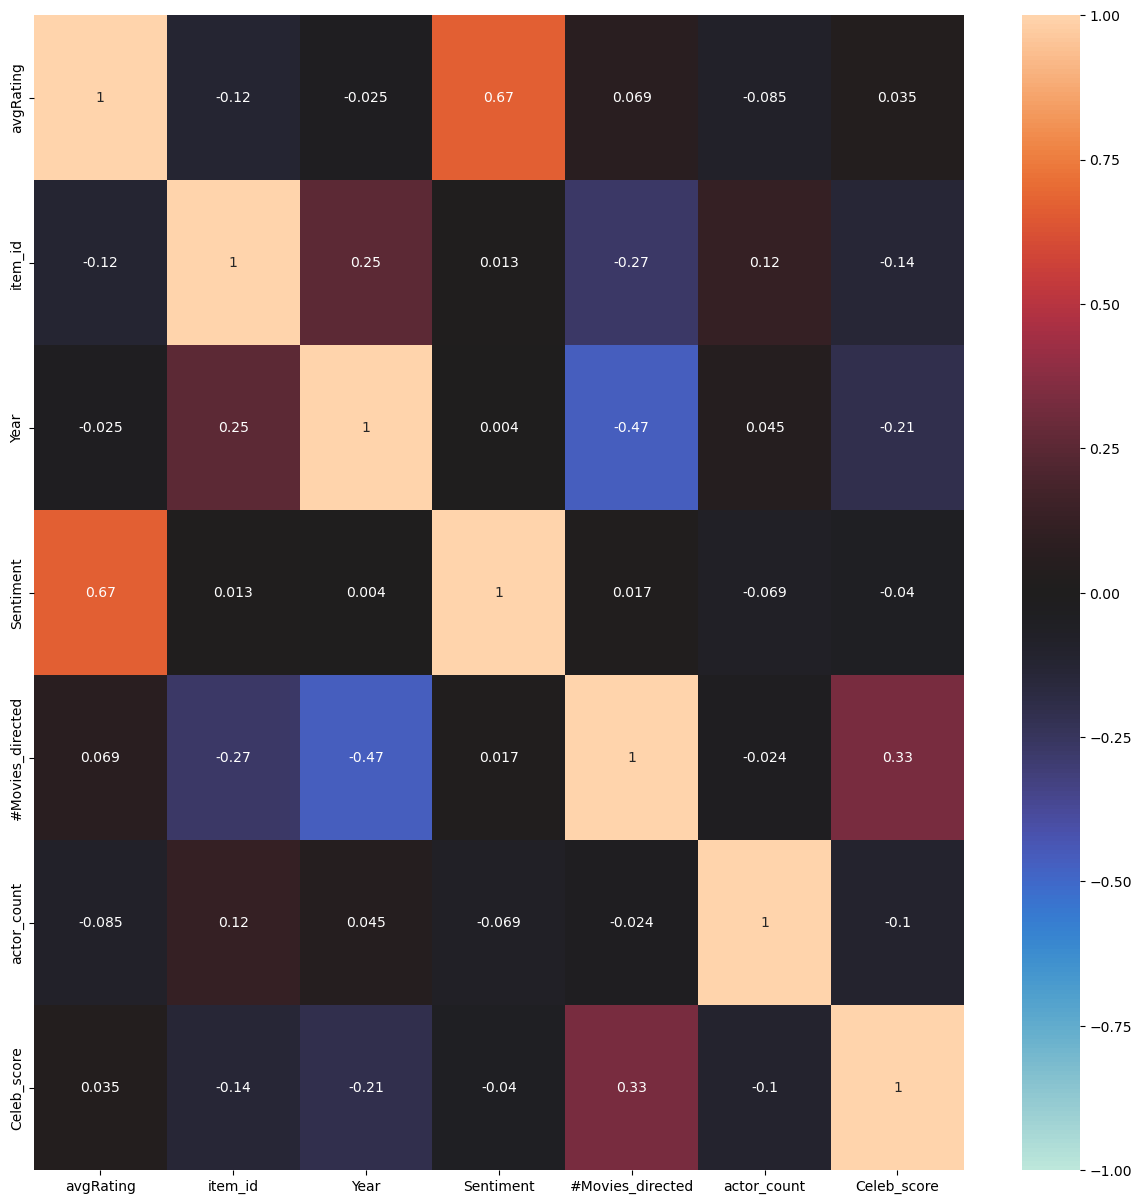

In [69]:
# actor count and celeb score seem to have a high correlation
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15,15))
sns.heatmap(linreg_movies_df.corr(), annot=True, center=0, vmin=-1, vmax=1)
plt.show()


### Reviews

In [70]:
reviews_raw = pd.read_json(r"C:\Users\micha\OneDrive\Desktop\Capstone\movie_dataset_public_final\raw\reviews.json", lines=True)

In [71]:
reviews_raw.head()

,item_id,txt
0,172063,"one-shot record of a belly dancer; ""Carmencita Dancing,"" one of a series of Edison short films featuring \r circus and vaudeville acts, displayed the... um... ""talents"" of a zaftig belly-dancer who agreed to undulate before the camera of the famous ""Black \r Maria"" studio. \r \r The dance was originally intended to be played in a Kinetoscope, a single -person arcade viewer connected to Edison's more famous invention, the phonograph. Through a pair of crude headphones, the latter device supplied an asynchronous soundtrack of ""hootchie-cootchie"" music. \r \r The Kinetograph camera here employed is so new -- even to its inventors \r -- that director Dickson has drastically ""overcranked"" the film, unintentionally producing one of the first examples of slow-motion.\r \r Carmencita's titillating movements were considered by many to be \r scandalous. Thus, the film prompted some of the earliest discussions of film censorship."
1,95541,"Banging Away..; Thomas Edison and William K.L. Dickson's ""Blacksmith Scene,"" was the first film shown publicly in 1893. This short is a brief look at 3 workers as they go about their daily ritual. Great piece of work for its time. In the early days of cinema, directors typically recorded everyday events such as the arrival of ships or workers leaving a factory. These short films were called ""actualities."" Later, with the advent of better equipment (which could record for longer), directors began to introduce more complicated narratives into film. 10* (10* Rating System)"
2,7065,unbelievable; I cannot understand how anyone can call this one of the greatest movies ever made. It is disgraceful and appalling. I guess it is still high entertainment to see white actors in black face and watch a film loaded with stereotype.
3,3739,"I'm still starry-eyed from it; I saw this last night on the Turner Classic Movies station. Wow. This is a perfect, shining, ebullient example of what was possible before The Code. The clever, witty, salacious dialogue! The compromising situations! The sheer sexuality permeating every scene, including the ones where the camera is on this side of a closed door! I am so glad that I finally saw this film, and would own a copy immediately were it available in any format. There's a lesson here. All together now: NEVER AGAIN with the censorship!!!"
4,1562,"Failed on every Front; Joel Schumacher who did an OK job on the third Batman Movie, has simply lost the plot on this one. Poorly cast with the exception of Robin and Ivy, this is far more like the 60's TV series than the comic books, and it just does not work. The Baddies are not menacing, Schwarzenegger rarely performs this badly and Uma Thurman, although she did an OK job was just a poor character. As for Batgirl, this is just too much. Bring back Keaton and Tim Burton and take Batman back to his dark roots. There is no future for Batman if it continues like this. 3/10"


In [72]:
reviews_raw.shape

(2624608, 2)

In [73]:
reviews_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624608 entries, 0 to 2624607
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   item_id  int64 
 1   txt      object
dtypes: int64(1), object(1)
memory usage: 40.0+ MB


In [74]:

reviews_raw.isna().sum(axis=0) / reviews_raw.shape[0]*100


item_id    0.0
txt        0.0
dtype: float64

In [75]:
reviews_grouped = reviews_raw.groupby('item_id').apply(lambda x: x.sample(n=min(len(x), 75)))

In [76]:
reviews_grouped = reviews_grouped.reset_index(drop = True)

In [77]:
# Cuts down to
reviews_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266871 entries, 0 to 1266870
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   item_id  1266871 non-null  int64 
 1   txt      1266871 non-null  object
dtypes: int64(1), object(1)
memory usage: 19.3+ MB


In [78]:
groupedtext = reviews_grouped.groupby('item_id')['txt'].apply(list)
review_text_df = pd.DataFrame(groupedtext).reset_index()
review_text_df = review_text_df.rename(columns={'txt': 'review_texts'})

In [79]:
review_text_df['review_texts'] = review_text_df['review_texts'].apply(lambda x: ' '.join(x))

In [80]:
review_text_df.head()

item_id  \
0        1   
1        2   
2        3   
3        4   
4        5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [81]:
review_text_df = review_text_df.fillna('')

In [82]:
#merging both columns so that the reviews are visible under each

movieratings_review_df = linreg_movies_df.merge(review_text_df, on='item_id', how='left')

Stuff to explore: 
count of actors, count of reviews, check for multiple directors

Sentiment analysis, count vectorization, 

instead of dummy variables, add a feature to show how many times the director has shown up.

or bin the directors (ie, novice, intermediate, explore the data)



In [83]:
# Still looks the same
movieratings_review_df.head(5)

avgRating  item_id  Year  Sentiment  #Movies_directed  actor_count  \
0       7.78        1  1995          1                 6            5   
1       6.53        2  1995          0                 9            4   
2       6.34        3  1995          0                11            4   
3       5.74        4  1995          0                 4            4   
4       6.15        5  1995          0                 7            5   

   Celeb_score  \
0        13.20   
1        13.00   
2        20.00   
3         8.25   
4        15.00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [84]:
# Dropping where we merged it on since item_id isn't really necessary
movieratings_review_df.drop(columns=['item_id'], inplace=True) 

In [85]:
movieratings_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63769 entries, 0 to 63768
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avgRating         63769 non-null  float64
 1   Year              63769 non-null  Int64  
 2   Sentiment         63769 non-null  int32  
 3   #Movies_directed  63769 non-null  int64  
 4   actor_count       63769 non-null  int64  
 5   Celeb_score       63769 non-null  float64
 6   review_texts      44620 non-null  object 
dtypes: Int64(1), float64(2), int32(1), int64(2), object(1)
memory usage: 3.7+ MB


In [86]:
movieratings_review_df.isna().sum(axis=0) / movieratings_review_df.shape[0]*100

avgRating            0.000000
Year                 0.000000
Sentiment            0.000000
#Movies_directed     0.000000
actor_count          0.000000
Celeb_score          0.000000
review_texts        30.028697
dtype: float64

In [87]:
movieratings_review_df = movieratings_review_df.dropna()

In [88]:
movieratings_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44620 entries, 0 to 47049
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avgRating         44620 non-null  float64
 1   Year              44620 non-null  Int64  
 2   Sentiment         44620 non-null  int32  
 3   #Movies_directed  44620 non-null  int64  
 4   actor_count       44620 non-null  int64  
 5   Celeb_score       44620 non-null  float64
 6   review_texts      44620 non-null  object 
dtypes: Int64(1), float64(2), int32(1), int64(2), object(1)
memory usage: 2.6+ MB


In [89]:
# creating rem/test split

# instantiating our independent and dependent variables 
X = movieratings_review_df.drop(columns='avgRating')
y = movieratings_review_df['avgRating']

print(X.shape, y.shape)

(44620, 6) (44620,)


In [90]:
# performing a rem_test_split to better evaluate our model

# error showing up, ask about this
X_rem, X_test, y_rem, y_test = train_test_split(X,
                                                y,
                                                test_size=0.3,
                                                random_state= 66)

# Checking the shape of the X compared to y
print(X_rem.shape, X_test.shape, y_rem.shape, y_test.shape)

(31234, 6) (13386, 6) (31234,) (13386,)


In [91]:


# Split the remainder set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rem,
                                                  y_rem,
                                                  test_size=0.2, 
                                                  random_state= 66)

# Checking the shape of the X compared to y
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(24987, 6) (6247, 6) (24987,) (6247,)


In [90]:
# Want to add a column for number of directors as well as number of starring actors
# will do this with NLP


Creating our custom tokenizer, we are using several components that make up how it works. First we are importing stopwords which are commonly occuring words in the english language that will be filtered. The tokizer also incorporates stemming, a way of cutting up words allowing for the root word to show, this allows for less variability or confusion when words can very much mean similar in context of a good or bad review (for example, mess, messy, and messiness). The tokenizer also filters out punctuation and returns nothing to avoid having random punctuation that does not convey any meaning in our word analysis.m

In [92]:
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

# allows for stemming words
stemmer = nltk.stem.PorterStemmer()

# Selects english stopwords as a variable
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    """
    Custome tokenizer for preprocessing.
    
    Input: string, raw document.
    Output: list of strings, cleaned & stemmed tokens
    """
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:

import string

# Initialize tokenizer
vectorizer = TfidfVectorizer(min_df = 1000, 
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 2))
# fit onto train and test data
vectorizer.fit(X_train['review_texts'])

X_train_transformed = vectorizer.transform(X_train['review_texts'])
X_val_transformed = vectorizer.transform(X_val['review_texts'])

X_train_transformed.shape

(24987, 8783)

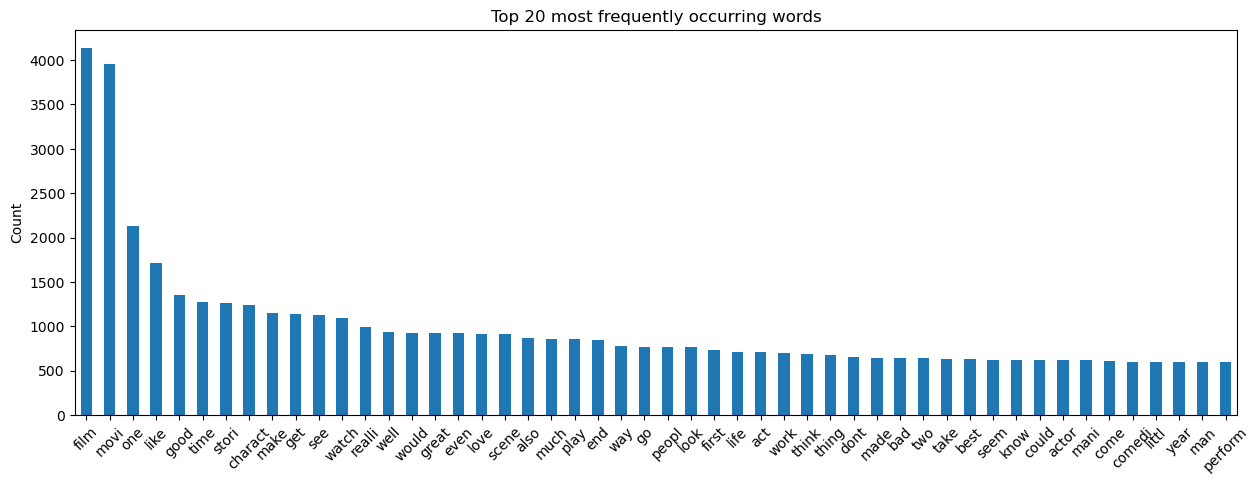

In [94]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=vectorizer.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(50).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 50 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [95]:
import string

# Initialize tokenizer
vectorizer = TfidfVectorizer(max_df = 0.95,
                             min_df = 1000, 
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 2))
# fit onto train and test data
vectorizer.fit(X_train['review_texts'])

X_train_transformed = vectorizer.transform(X_train['review_texts'])
X_val_transformed = vectorizer.transform(X_val['review_texts'])

X_test_transformed = vectorizer.transform(X_test['review_texts'])

X_train_transformed.shape

(24987, 8773)

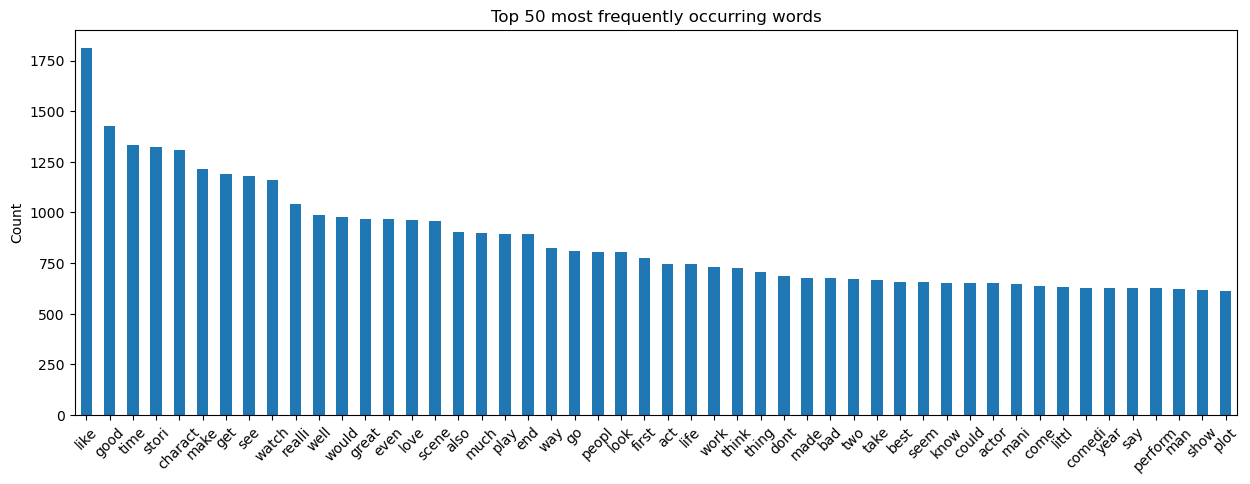

In [97]:
# Creates an array so we can graph it.
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=vectorizer.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(50).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 50 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [105]:
# converting sparse matrix to dense
# Results show same row size as the train dataset

word_counts_dftrain = pd.DataFrame(X_train_transformed.todense(), columns = vectorizer.get_feature_names_out())
word_counts_dftrain

,0,1,1 2,10,10 10,10 minut,10 star,10 year,100,1000,...,youv never,youv seen,zani,zero,zombi,zone,zoom,,,
0,0.0,0.000000,0.000000,0.018700,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.0,0.002870,0.000000,0.023697,0.005087,0.004623,0.000000,0.000000,0.003540,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.020387,0.0
2,0.0,0.003208,0.000000,0.002648,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.004991,0.0,0.000000,0.012011,0.000000,0.013327,0.0,0.009765,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.057314,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24982,0.0,0.010146,0.003081,0.005983,0.000000,0.000000,0.000000,0.004715,0.001788,0.0,...,0.0,0.000000,0.0,0.002209,0.018994,0.000000,0.000000,0.0,0.011765,0.0
24983,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.047060,0.000000,0.000000,0.000000,0.0,0.000000,0.0
24984,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.119645,0.0
24985,0.0,0.004684,0.000000,0.007734,0.000000,0.007544,0.008628,0.000000,0.011553,0.0,...,0.0,0.000000,0.0,0.007140,0.000000,0.000000,0.000000,0.0,0.033268,0.0


In [112]:
X_train_words = pd.concat([X_train.reset_index(drop=True), word_counts_dftrain.reset_index(drop=True)], axis=1)
X_train_words.sample(2)

Year  Sentiment  #Movies_directed  actor_count  Celeb_score  \
11765  2004          0                20            5         14.0   
10388  2014          0                 3            5         11.6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [113]:
# Repeat process for Validation 

# converting sparse matrix to dense
# Results show same row size as the val dataset

word_counts_dfval = pd.DataFrame(X_val_transformed.todense(), columns = vectorizer.get_feature_names_out())
word_counts_dfval

,0,1,1 2,10,10 10,10 minut,10 star,10 year,100,1000,...,youv never,youv seen,zani,zero,zombi,zone,zoom,,,
0,0.0,0.002348,0.0,0.009690,0.0,0.000000,0.004324,0.0,0.002895,0.009563,...,0.0,0.000000,0.0,0.003578,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.003009,0.0,0.002484,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.000000,0.0,0.010889,0.0,0.021242,0.000000,0.0,0.000000,0.000000,...,0.0,0.041044,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6242,0.0,0.005757,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.005841,0.0
6243,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
6244,0.0,0.000000,0.0,0.007549,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
6245,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [114]:
X_val_words = pd.concat([X_val.reset_index(drop=True), word_counts_dfval.reset_index(drop=True)], axis=1)
X_val_words.sample(2)

Year  Sentiment  #Movies_directed  actor_count  Celeb_score  \
4698  1981          0                19            3     1.333333   
1953  1939          0                39            5    12.400000   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
# Repeat process for Test

In [115]:
# converting sparse matrix to dense
# Results show same row size as the val dataset

word_counts_dftest = pd.DataFrame(X_test_transformed.todense(), columns = vectorizer.get_feature_names_out())
word_counts_dftest

,0,1,1 2,10,10 10,10 minut,10 star,10 year,100,1000,...,youv never,youv seen,zani,zero,zombi,zone,zoom,,,
0,0.0,0.002741,0.0,0.004525,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.004264,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.016686,0.011407
1,0.0,0.000000,0.0,0.013024,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.0,0.003813,0.0,0.0,0.000000,0.0,0.017090,0.0,...,0.00982,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.014060,0.000000
3,0.0,0.000000,0.0,0.005833,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.012644,0.0,0.046972,0.0,0.0,0.000000,0.0,0.007797,0.0,...,0.00000,0.000000,0.0,0.019273,0.059176,0.011182,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
13382,0.0,0.000000,0.0,0.014836,0.0,0.0,0.033103,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
13383,0.0,0.013362,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.006779,0.000000
13384,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [116]:
X_test_words = pd.concat([X_test.reset_index(drop=True), word_counts_dftest.reset_index(drop=True)], axis=1)
X_test_words.sample(2)

Year  Sentiment  #Movies_directed  actor_count  Celeb_score  \
585   2013          1                10            5         10.2   
8528  1950          0                36            5          3.4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [117]:
# Doublechecking the train, val and test X and y

print(X_train_words.shape, y_train.shape)

print(X_val_words.shape, y_val.shape)

print(X_test_words.shape, y_test.shape)

(24987, 8779) (24987,)
(6247, 8779) (6247,)
(13386, 8779) (13386,)


In [119]:
# merge train X and y into one dataframe

train_df = pd.concat([X_train_words, y_train], axis=1)

# Save the merged dataframe to a CSV file
train_df.to_csv(r'C:\Users\micha\OneDrive\Desktop\Capstone\train_df.csv', index=False)


In [120]:
# Repeat process for val

val_df = pd.concat([X_val_words, y_val], axis=1)

val_df.to_csv(r'C:\Users\micha\OneDrive\Desktop\Capstone\val_df.csv', index=False)

In [121]:
# Repeat process for test

test_df = pd.concat([X_test_words, y_test], axis=1)

test_df.to_csv(r'C:\Users\micha\OneDrive\Desktop\Capstone\test_df.csv', index=False)